In [1]:
#!pip install nltk bs4

In [2]:
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import pandas as pd
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [4]:
url = 'https://finviz.com/quote.ashx?t=AMZN'

In [5]:
web_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}
tickers = ['AMZN', 'GOOG', 'TSLA']
for tick in tickers:
    url = web_url + tick
    req = Request(url=url,headers={"User-Agent": "Chrome"}) 
    response = urlopen(req)    
    html = BeautifulSoup(response,"html.parser")
    news_table = html.find(id='news-table')
    news_tables[tick] = news_table

In [6]:
amazon = news_tables['AMZN']
amazon_tr = amazon.findAll('tr')
for x, table_row in enumerate(amazon_tr):
    a_text = table_row.a.text
    td_text = table_row.td.text
    print(a_text)
    print(td_text)
    if x == 3:
        break


Amazon plans to add 2,500 office jobs in Southern California
May-03-22 08:00AM  
2 Stock Split Stocks That Crushed Earnings, and 1 That Didn't
07:45AM  
Traders Face Up to Reality as Nasdaq 100 Profit Forecasts Drop
06:53AM  
Inflation: Clorox is jacking up prices (again)
06:36AM  


In [7]:
news_list = []
for file_name, news_table in news_tables.items():
    for i in news_table.findAll('tr'):
        
        text = i.a.get_text() 
        
        date_scrape = i.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        tick = file_name.split('_')[0]
        
        news_list.append([tick, date, time, text])


In [8]:
import nltk
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zheng/nltk_data...


True

In [9]:
vader = SentimentIntensityAnalyzer()
columns = ['ticker', 'date', 'time', 'headline']
news_df = pd.DataFrame(news_list, columns=columns)
scores = news_df['headline'].apply(vader.polarity_scores).tolist()
scores_df = pd.DataFrame(scores)
news_df = news_df.join(scores_df, rsuffix='_right')
news_df['date'] = pd.to_datetime(news_df.date).dt.date
print(news_df.head())

  ticker        date     time  \
0   AMZN  2022-05-03  08:00AM   
1   AMZN  2022-05-03  07:45AM   
2   AMZN  2022-05-03  06:53AM   
3   AMZN  2022-05-03  06:36AM   
4   AMZN  2022-05-03  05:52AM   

                                            headline    neg    neu    pos  \
0  Amazon plans to add 2,500 office jobs in South...  0.000  0.841  0.159   
1  2 Stock Split Stocks That Crushed Earnings, an...  0.259  0.741  0.000   
2  Traders Face Up to Reality as Nasdaq 100 Profi...  0.150  0.643  0.207   
3     Inflation: Clorox is jacking up prices (again)  0.000  1.000  0.000   
4  These 3 Growth Stocks Got Pummeled Last Week: ...  0.000  0.794  0.206   

   compound  
0    0.1779  
1   -0.4215  
2    0.2023  
3    0.0000  
4    0.3818  


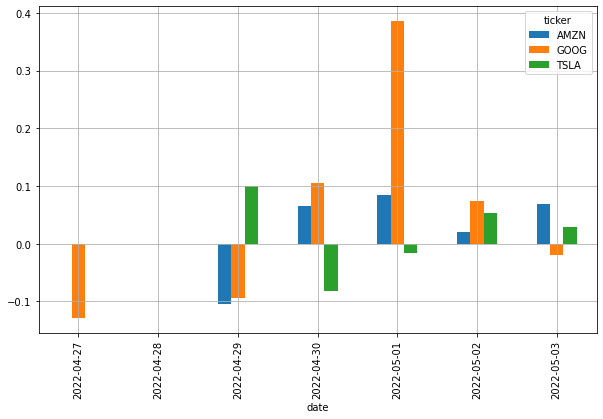

In [10]:
plt.rcParams['figure.figsize'] = [10, 6]
mean_scores = news_df.groupby(['ticker','date']).mean()
mean_scores = mean_scores.unstack()
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
mean_scores.plot(kind = 'bar')
plt.grid()
plt.show()